# Private gardens and demographics in Sant Just using python

In this post I will analyse the association between private gardens and demographics (gender, age, nationality) for the town of Sant Just Desvern (Barcelona, Spain) using remote sensing data and python tools. The motivation behind this post is threefold. First, I'd like to  get more familiar with packages I have used but that I want to explore further (*geopandas*, *shapely*, *rasterio*, *rasterstats*, *folium*, *seaborn*). Second, I will use the extracted information to correlate greenness with demographic variables in the town and thus test basic statistical plotting capabilities. Third, Sant Just is my hometown so I'm always eager to explore it! :)

As a bit of a motivational background, Sant Just is a wealthy residential town (~19k inhabitants) near Barcelona, Spain. Within the town, there are important differences between the historic town (in the centre) and the newly created residential areas. My hypothesis is that wealthier residents will have more private gardens (residential greenness). Unfortunately, the last census is from 2011 (a lot of development has happened) so we can only compare to demographic data, which is up to date. With that data, I think that we will observe how older residents (clustered in the centre) have less private gardens, while non-Spanish residents (mostly from rich countries of the EU and the US) will have a greater access.

The overview of the post is the following:
1. We'll have a look at the town.
2. We'll derive residential areas (we want to omit public parks and natural areas to get as close as possible to private gardens).
3. We'll process NDVI remotely sensed data.
4. We'll clean population data.
5. We'll merge NDVI and population data.
6. We'll analyse the relationship between demographics and greenness.

This script was written as a Jupyter notebook and converted to a markdown file to be able to merge it in the *blogdown* R-based blog. Let's get started!

In [50]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from matplotlib import pyplot
import folium
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Study area

Before we start, let's have a look at this beautiful town! (and try folium capabilities while at it! :) Sant Just is a residential town neighbouring Barcelona touching the Collserola mountain range, so a large part of it are natural areas (mostly shrubland and forest).

In [51]:
# Read boundaries
bound_file = "data/boundaries/sant-just.geojson"
stjust = gpd.read_file(bound_file)

# Start folium
f = folium.Figure(width=450, height=400)
m = folium.Map(location=[41.391421, 2.077184], zoom_start=13)

# Add boudnaries
folium.GeoJson(stjust, name='Sant Just boundaries').add_to(m)

# And process
folium.LayerControl().add_to(m)
f.add_child(m)
f

## 2. Preprocessing boundaries and land use

First, we read the municipality boundaries and the land use data of the region. Land cover data (created by [GRUMETS group of CREAF](http://www.creaf.cat/ca/recerca/grumets)) come in raster format and according to the documentation they are derived via supervised classification of Sentinel 2 data (10 m) and correspond to 2017. Data can be downloaded [here](https://territori.gencat.cat/ca/01_departament/12_cartografia_i_toponimia/bases_cartografiques/medi_ambient_i_sostenibilitat/usos-del-sol/). Prior to reading the data, I have clipped the raster to the boundary polygon of Sant Just to avoid a data overload, and polygonized it using GRASS. Here, we do some data cleaning to reclassify the land use types.

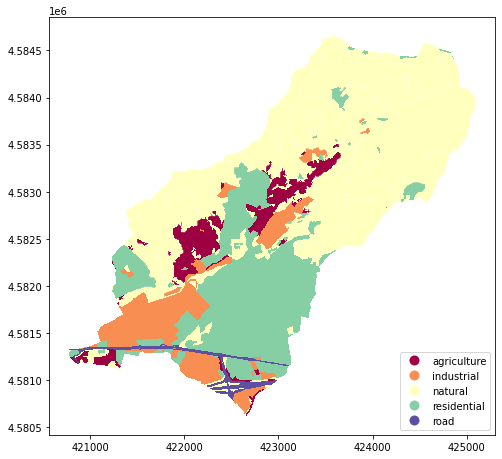

In [52]:
# Read land use data
lc = gpd.read_file("data/landcover/lc-stjust.geojson")     

# Classes for reclassification
water = [1,2]
road = 4
residential = [5,6]
industrial = 7
agriculture = [8,9,10,11,12,24,25]
natural = list(range(9,25))
natural.append(3)

# Reclassify
lc["lctype"] = ''

for index, row in lc.iterrows():
    if row['DN'] in water:
        lc['lctype'].values[index] = 'water'
    elif row['DN'] == road:
        lc['lctype'].values[index] = 'road'
    elif row['DN'] in residential:
        lc['lctype'].values[index] = 'residential'
    elif row['DN'] == industrial:
        lc['lctype'].values[index] = 'industrial'
    elif row['DN'] in agriculture:
        lc['lctype'].values[index] = 'agriculture'
    elif row['DN'] in natural:
        lc['lctype'].values[index] = 'natural'

lc.plot(column = "lctype", cmap = "Spectral", legend = True, figsize = (8,8), legend_kwds={'loc': 'lower right'});

Since we are interested in private gardens only we will focus on the residential class. Note that since we do not have data on minor streets, street trees will be inevitably included in the data.

## 3. Preprocessing remote sensing data

Now that our study area is defined, let's move on and read the remote sensing data, which can be freely downloaded at the Catalan Cartographic insitute at [this link](https://www.icgc.cat/Descarregues/Imatges-aeries-i-de-satel-lit/Altres-imatges-aeries), and corresponds to the RGB ortophotos and NIR data collected each year by the insitute at very high resolution, from which an NDVI layer is computed. I downloaded data for 2019 at 0.9m spatial resolution and cropped the data to our study area and resampled to 5m in QGIS before importing the data here. Let's exclude the non-residential, remove values smaller than 0 (possibly pools), and have a look.

In [53]:
# Open the data
ndvi = rio.open("data/remote_sensing/stjust_ndvi_5m.tif")
# print(ndvi.meta)

# Clip it
reslc = lc.loc[lc['lctype'] == 'residential'] # Filter residential polygons
geoms = [g for g in reslc['geometry']] # Extract geometry from residential polygons
out_image, out_transform = mask(ndvi, geoms, crop=False) # Mask
out_meta = ndvi.meta # Update metadata and write
out_meta.update({"transform": out_transform})

# Remove water
out_image[out_image<0] = np.nan

# Write to disk and open again!
with rio.open("data/remote_sensing/stjust_ndvi_5m_res_nowater.tif", "w", **out_meta) as dest:
    dest.write(out_image)
ndvi_pro = rio.open("data/remote_sensing/stjust_ndvi_5m_res_nowater.tif")

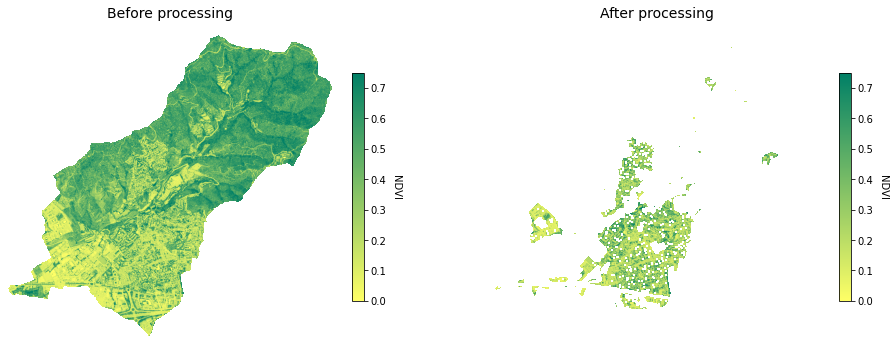

In [47]:
# Display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# Plot 1: Before processing
ndviplot1 = ax1.imshow(ndvi.read(1), cmap='summer_r', vmin=0, vmax=0.75)
ax1.set_title("Before processing", fontsize=14)
cbar1 = fig.colorbar(ndviplot1, ax = ax1, shrink = 0.7)
cbar1.ax.get_yaxis().labelpad = 15
cbar1.ax.set_ylabel('NDVI', rotation=270)
ax1.set_axis_off()
ax1.axis('equal')

# Plot 2: Post-processing
ndviplot2 = ax2.imshow(ndvi_pro.read(1), cmap='summer_r', vmin=0, vmax=0.75)
ax2.set_title("After processing", fontsize=14)
cbar2 = fig.colorbar(ndviplot2, ax = ax2, shrink = 0.7)
cbar2.ax.get_yaxis().labelpad = 15
cbar2.ax.set_ylabel('NDVI', rotation=270)
ax2.set_axis_off()
ax2.axis('equal')

plt.show()

I can't help to think of a cheese looking at the processed layer :) But anyway, it was successful and we can continue!

## 4. Preprocessing population data

Population data are based on the [gridded population dataset](https://biblio.idescat.cat/publicacions/Record/21104) for 2016 done by the Statistical Institute of Catalunya. Let's read the data and see what we have.

In [56]:
# Read popluation data
popu = gpd.read_file("data/population/stjust_population.geojson")
# Clean superfluous columns
popu = popu.drop(columns=['ID', 'P_NASC_CAT', 'P_NASC_RES', 'P_NASC_EST', 'ID_PARE', 'ORDRE_DIV'])
# Give meaningful names
popu = popu.rename(columns={"HOMES":"Men", "DONES":"Women", "P_65_I_MES":"P_older_65",
                            "P_ESPANYOL":"Spanish", "P_ESTRANGE":"Foreign"})
# Get summary stats of the data
popu.describe()

,TOTAL,Men,Women,P_0_14,P_15_64,P_older_65,Spanish,Foreign
count,189.000000,187.000000,187.000000,101.000000,186.000000,104.000000,112.000000,112.000000
mean,84.703704,41.090909,44.272727,20.683168,55.198925,24.288462,93.303571,14.500000
std,98.881118,47.868742,51.670539,19.626987,65.802228,30.879243,110.061477,14.329457
min,17.000000,7.000000,8.000000,0.000000,8.000000,0.000000,8.000000,0.000000
25%,35.000000,16.000000,17.500000,9.000000,22.250000,11.000000,30.750000,7.750000
50%,54.000000,26.000000,28.000000,14.000000,35.000000,16.000000,53.000000,12.000000
75%,98.000000,46.500000,51.500000,23.000000,63.000000,26.000000,107.250000,18.000000
max,765.000000,365.000000,400.000000,98.000000,582.000000,234.000000,714.000000,108.000000


We have total population counts with gender, age and origin disaggregation. Let's check how many areas we have and whether we have missing values:

In [57]:
# Check number of areas and nulls
print('Number of areas: ' + str(popu.shape[0]))
print('\nNumber of missing data:')
print(popu.isna().sum())

Number of areas: 197

Number of missing data:
TOTAL          8
Men           10
Women         10
P_0_14        96
P_15_64       11
P_older_65    93
Spanish       85
Foreign       85
GRD_FIXID      0
geometry       0
dtype: int64


We have a fair amount of missing values, possibly because of statistical secret (no individual can be identified). Let's have a look at the geometries and the spatial distribution of some of the variables:

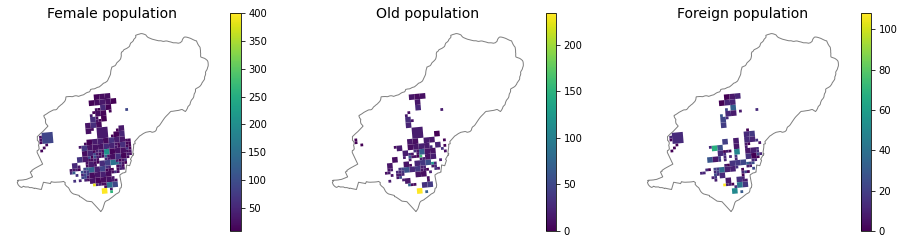

In [34]:
# Graph
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
ax1.set_title("Female population", fontsize=14)
ax1.set_axis_off()
stjust.plot(ax = ax1, color='white', edgecolor='grey');
popu.plot(ax = ax1, column = 'Women', legend = True);
ax2.set_title("Old population", fontsize=14)
ax2.set_axis_off()
stjust.plot(ax = ax2, color='white', edgecolor='grey');
popu.plot(ax = ax2, column = 'P_older_65', legend = True);
ax3.set_title("Foreign population", fontsize=14)
ax3.set_axis_off()
stjust.plot(ax = ax3, color='white', edgecolor='grey');
popu.plot(ax = ax3, column = 'Foreign', legend = True);

Having a look at the raw counts only we cannot see any clear pattern, although the missing areas can be clearly appreciated. Let's quickly compute ratios with respect to the total counts to see if we observe anything else.

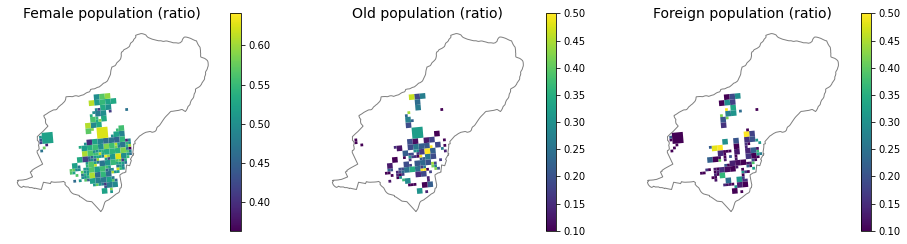

In [58]:
# Compute ratios
popu['female_r'] = popu['Women']/popu['TOTAL']
popu['old_r'] = popu['P_older_65']/popu['TOTAL']
popu['foreign_r'] = popu['Foreign']/popu['TOTAL']

# And plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
ax1.set_title("Female population (ratio)", fontsize=14)
ax1.set_axis_off()
stjust.plot(ax = ax1, color='white', edgecolor='grey');
popu.plot(ax = ax1, column = 'female_r', legend = True);
ax2.set_title("Old population (ratio)", fontsize=14)
ax2.set_axis_off()
stjust.plot(ax = ax2, color='white', edgecolor='grey');
popu.plot(ax = ax2, column = 'old_r', legend = True, vmax = 0.5, vmin = 0.1); # Narrow range to see more contrast
ax3.set_title("Foreign population (ratio)", fontsize=14)
ax3.set_axis_off()
stjust.plot(ax = ax3, color='white', edgecolor='grey');
popu.plot(ax = ax3, column = 'foreign_r', legend = True, vmax = 0.5, vmin = 0.1); # Narrow range to see more contrast

With these we can have start to see that there are more old people in the centre of the town, while more foreign people live in the northwest and northeast parts of the central cluster.

## 5. Obtaining mean NDVI per area

Now we will extract the mean NDVI per area. The resulting value will be an indication of the private green spaces (i.e. private gardens) each of the areas has on average. As mentioned before, street trees will be unfortunately included as our land use data did not differentiate residential streets vs. actual dwellings.

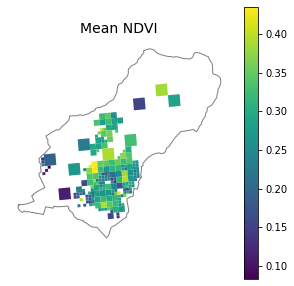

In [59]:
# Compute extraction of zonal statistics
affine = ndvi_pro.transform
array = ndvi_pro.read(1)
mean_ndvi_df = pd.DataFrame(zonal_stats(popu, array, affine=affine, stats='mean'))
mean_ndvi_df = mean_ndvi_df.rename(columns={"mean": "mean_ndvi"})

# adding statistics back to original GeoDataFrame
popu_green = pd.concat([popu, mean_ndvi_df], axis=1)

# And plot
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("Mean NDVI", fontsize=14)
ax.set_axis_off()
stjust.plot(ax = ax, color='white', edgecolor='grey');
popu_green.plot(ax = ax, column = 'mean_ndvi', legend = True);

The distribution of mean NDVI has small values in the centre of the town, while areas around it have a larger amount of greenness.

## 6. Analysing the association between demographics and greenness

In order to analyse the distribution of NDVI by demographic characteristic, we will create a record for each count that a given area has, and then plot side-by-side NDVI boxplots to compare the different demographic levels. We'll do this using this function:

In [37]:
def expand_areal_counts(df, demo_var, green_var):
    # Remove missing and coerce count variable to integer
    df = df.dropna(how='any', subset=[demo_var, green_var])
    df[demo_var] = df[demo_var].astype('int64')
    
    # Empty dataframe
    res = pd.DataFrame(columns=['demo_var', 'mean_ndvi'])
    
    # Loop through rows
    for index, row in df.iterrows():
        
        # create lower level df with number of rows equal to the count
        count = row[demo_var]
        res2 = pd.DataFrame(columns=['demo_var', 'mean_ndvi'])
        for c in range(count):
            res3 = pd.DataFrame({'demo_var': [demo_var], 'mean_ndvi': [row[green_var]]})
            res2 = pd.concat([res2, res3], axis=0)
            
        # And bind to the higher level result and continue
        res = pd.concat([res, res2], axis=0)                       
        
    return res

### By gender

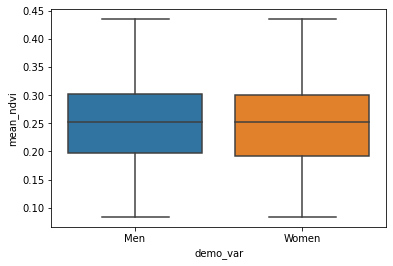

In [60]:
men = expand_areal_counts(popu_green, 'Men', 'mean_ndvi')
women = expand_areal_counts(popu_green, 'Women', 'mean_ndvi')
gender = pd.concat([men, women], axis=0)
# Boxplot
sns.boxplot(x = 'demo_var', y = 'mean_ndvi', data=gender);

There are virtually no differences between genders.

### By age

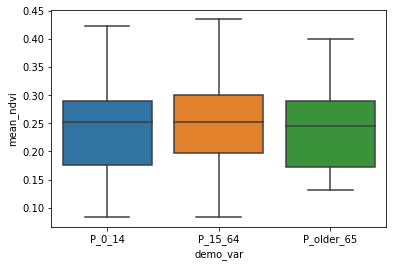

In [40]:
young = expand_areal_counts(popu_green, 'P_0_14', 'mean_ndvi')
middle = expand_areal_counts(popu_green, 'P_15_64', 'mean_ndvi')
old = expand_areal_counts(popu_green, 'P_older_65', 'mean_ndvi')
age = pd.concat([young, middle, old], axis=0)
# Boxplot
sns.boxplot(x = 'demo_var', y = 'mean_ndvi', data=age);

These results suggest that adults tend to have more green areas in their residences than the older group, although the differences are minimal.

### By origin

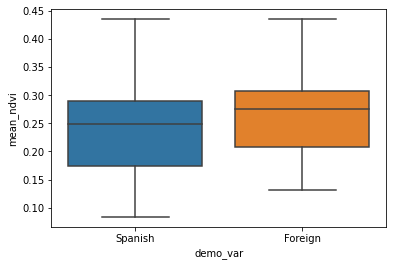

In [41]:
native = expand_areal_counts(popu_green, 'Spanish', 'mean_ndvi')
foreign = expand_areal_counts(popu_green, 'Foreign', 'mean_ndvi')
origin = pd.concat([native, foreign], axis=0)
# Boxplot
sns.boxplot(x = 'demo_var', y = 'mean_ndvi', data=origin);

People with a nationality different from Spanish appear to have a larger amount of green areas in their residences.

## Conclusions

Aligned with my initial hypothesis, we have seen how foreign residents (mostly from France, Germany and the US) have more private gardens than the rest of the residents, while older people that live in the historic centre have slightly less. I think that if we had had access to income, the differences would be much larger. Maybe I can revisit the analysis once the 2021 census is published! :)